In [54]:
import gc
gc.collect()

326

In [1]:
import numpy as np
import skimage.measure
# import pydicom
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.examples.tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
import matplotlib.pyplot as plt
from keras import backend as K
import keras
from PIL import Image
from skimage.transform import rescale, rotate
import vtk
from vtk.util import numpy_support

In [2]:
# plt.gray()
os.chdir('C:/Users/span/Documents/CNN/')

In [6]:
# list1 = os.listdir('./04_prediction')
# for i in list1:
#     os.mkdir('./04_prediction/'+str(i)+'/'+str(i)+'_prepro')
#     os.mkdir('./04_prediction/'+str(i)+'/'+str(i)+'_predict_bmp')
#     os.mkdir('./04_prediction/'+str(i)+'/'+str(i)+'_predict_bmp_dicom')

In [75]:
def dicomtopng(number1):
    # read dicom _dl_input
    PathDicom = "04_prediction/"+str(number1)+'/'+str(number1)+"_orig/"
    # PathDicom = "01_perprocess/"+str(number1)+'/'+str(number1)+"_in/"
    reader = vtk.vtkDICOMImageReader()
    reader.SetDirectoryName(PathDicom)
    reader.Update()
    # Load dimensions using `GetDataExtent`
    _extent = reader.GetDataExtent()
    ConstPixelDims = [_extent[1]-_extent[0]+1, _extent[3]-_extent[2]+1, _extent[5]-_extent[4]+1]
    # Load spacing values
    ConstPixelSpacing = reader.GetPixelSpacing()
    # Get the 'vtkImageData' object from the reader
    imageData = reader.GetOutput()
    # Get the 'vtkPointData' object from the 'vtkImageData' object
    pointData = imageData.GetPointData()
    # Ensure that only one array exists within the 'vtkPointData' object
    assert (pointData.GetNumberOfArrays()==1)
    # Get the `vtkArray` (or whatever derived type) which is needed for the `numpy_support.vtk_to_numpy` function
    arrayData = pointData.GetArray(0)
    # Convert the `vtkArray` to a NumPy array
    ArrayDicom = numpy_support.vtk_to_numpy(arrayData)
    # Reshape the NumPy array to 3D using 'ConstPixelDims' as a 'shape'
    ArrayDicom = ArrayDicom.reshape(ConstPixelDims, order='F')
    a_in = np.where(ArrayDicom <= -1000, -999, ArrayDicom)
#     a = np.moveaxis(a, 0, 1)
    for i in range(a_in.shape[2]):
        image = a_in[:, :, i].copy()
        image = rescale(image, (256/a_in[:, :, i].shape[1]), preserve_range=True, anti_aliasing=False)
        image = (((image - a_in.min()) / (a_in.max() - a_in.min())) * 255.9).astype(np.uint8)
        img0 = Image.fromarray(image.astype(np.uint8))
        img0.save("04_prediction/"+str(number1)+'/'+str(number1)+'_prepro/'+str(number1)+"_image_"+str("{0:03}".format(i))+".png")
    return a_in.shape

In [76]:
list1 = os.listdir('./04_prediction')

In [77]:
a_shape = dicomtopng(list1[0])

In [78]:
# load for countinue trainning
model = tf.keras.models.load_model('03_model/Model_orig_tensflow.ep20_4sample-4.82.h5')

In [79]:
path5 = "04_prediction/"+str(list1[0])+'/'+str(list1[0])+"_prepro"

In [80]:
def read_image1(img_path: str) -> dict:
    image = tf.io.read_file(img_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)
    return {'image': image}

In [81]:
def findbatchsize(number):
    list1 = []
    for i in range(1, 65):
        if number % i == 0:
            list1.append(i)
    return max(list1)

In [82]:
findbatchsize(a_shape[2])

2

In [83]:
# from run
SEED = 1024

batch_size = findbatchsize(a_shape[2])
target_size=(256, 256)

dataset0 = tf.data.Dataset.list_files(path5+"/*.png", seed=SEED, shuffle=False)
dataset0 = dataset0.map(read_image1)

In [84]:
@tf.function
def normalize(input_image: tf.Tensor) -> tuple:
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image

@tf.function
def load_image_pre(datapoint: dict) -> tuple:
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    
    input_image = normalize(input_image)

    return input_image

In [85]:
IMG_SIZE = 256

dataset = {"image": dataset0}

predict = dataset['image'].map(load_image_pre, num_parallel_calls=tf.data.experimental.AUTOTUNE)
predict = predict.cache().batch(batch_size)
predict = predict.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)  


In [86]:
predictions = model.predict(predict, steps=len(os.listdir(path5)) // batch_size)
predictions.shape

(562, 256, 256, 5)

In [87]:
predictions2 = predictions[tf.newaxis, ...]
predictions2.shape

(1, 562, 256, 256, 5)

In [88]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [89]:
from PIL import Image, ImageOps
from skimage.transform import rescale, rotate
from skimage import morphology
from skimage.color import rgb2gray

In [90]:
def predictoutput(input_image, resize):
    image = create_mask(input_image)
#     image = rescale(image, (resize/image.shape[0]), preserve_range=True, anti_aliasing=False)
    image = tf.image.resize(image, (resize,resize))
    image = tf.image.rot90(image, k = 1)
    img0 = image * 255
#     img0 = Image.fromarray(tf.cast(image, np.uint8))
#     tf.cast(input_image, tf.float32)
    return img0

In [91]:
path6 = "04_prediction/"+str(list1[0])+'/'+str(list1[0])+"_predict_bmp"

# export master_image
for i in range(predictions2.shape[1]):
    img0 = predictoutput(predictions2[:, i, :, :],a_shape[0])
    tf.keras.preprocessing.image.save_img((path6+"/"+str(list1[0])+"_pred_rec00000"+str("{0:03}".format(i))+".bmp"),img0)

# Loop

In [94]:
def loop1():
    for i in range(1,len(list1)+1):
        a_shape = dicomtopng(list1[i])
        path5 = "04_prediction/"+str(list1[i])+'/'+str(list1[i])+"_prepro"
        SEED = 1024
        batch_size = findbatchsize(a_shape[2])
        target_size=(256, 256)
        dataset0 = tf.data.Dataset.list_files(path5+"/*.png", seed=SEED, shuffle=False)
        dataset0 = dataset0.map(read_image1)
        IMG_SIZE = 256
        dataset = {"image": dataset0}
        predict = dataset['image'].map(load_image_pre, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        predict = predict.cache().batch(batch_size)
        predict = predict.prefetch(buffer_size=tf.data.experimental.AUTOTUNE) 
        predictions = model.predict(predict, steps=len(os.listdir(path5)) // batch_size)
        predictions2 = predictions[tf.newaxis, ...]
        path6 = "04_prediction/"+str(list1[i])+'/'+str(list1[i])+"_predict_bmp"
        for j in range(predictions2.shape[1]):
            img0 = predictoutput(predictions2[:, j, :, :],a_shape[0])
            tf.keras.preprocessing.image.save_img((path6+"/"+str(list1[i])+"_pred_rec00000"+str("{0:03}".format(j))+".bmp"),img0)
        

In [ ]:
loop1()

# TEST ZONE

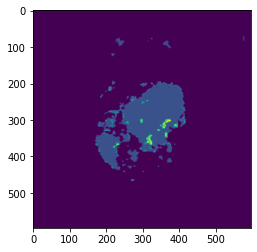

In [17]:
img1 = predictoutput(predictions2[:, 226, :, :],596)
plt.imshow(img1)

In [102]:
tf.keras.preprocessing.image.save_img('01_perprocess/37/file.bmp',img1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


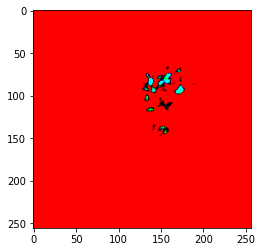

In [16]:
plt.imshow(skimage.transform.rotate(predictions[226,:,:],0))

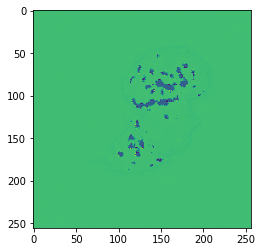

In [17]:
converted = tf.image.rgb_to_grayscale(predictions[326,:,:,:].astype(np.uint8))
plt.imshow(converted)

In [14]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [ ]:
display(predictions[251,:,:])

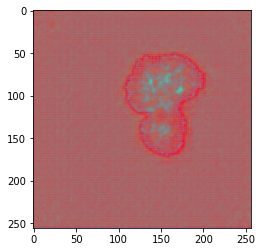

In [18]:
plt.imshow(tf.keras.preprocessing.image.array_to_img(skimage.transform.rotate(predictions[226,:,:],0)))

In [19]:
image = predictions[226,:,:,:].copy()

image1 = rgb2gray(image)
image2 = np.where(image1 <= 0, 0, image1)
#     image = rescale(image, (resize1/a_in[:, :, i].shape[1]), preserve_range=True, anti_aliasing=False)
# image2 = (((image1 - image1.min()) / (image1.max() - image1.min())) * 255.9).astype(np.uint8)
image3 = image2 >0
# image3 = skimage.morphology.remove_small_objects(image3, 10)
# image3 = skimage.morphology.remove_small_objects(image3, 100)
# image3 = skimage.transform.rotate(image3,90)
# image3 = (((image3 - image3.min()) / (image3.max() - image3.min())) * 255.9).astype(np.uint8)

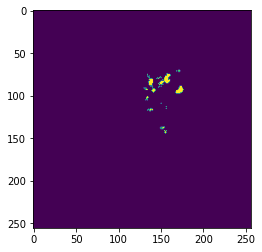

In [20]:
plt.imshow(image3)

In [27]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [28]:
def read_image2(img_path):
    image = tf.io.read_file(img_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)
    return {'image': image}

In [32]:
# image = read_image2(path5+"/37_image_226.png")
image = tf.io.read_file(path5+"/37_image_226.png")
image = tf.image.decode_png(image, channels=3)
image = tf.image.convert_image_dtype(image, tf.uint8)
image = tf.image.resize(image, (256, 256))
image = tf.cast(image, tf.float32) / 255.0
pred_mask = model.predict(image[tf.newaxis, ...])
mask1 = create_mask(pred_mask)

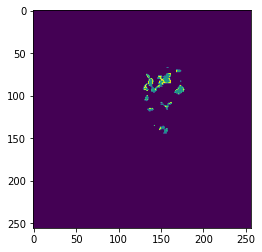

In [33]:
plt.imshow(mask1)

In [68]:
def create_mask2(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [62]:
p2 = predictions[tf.newaxis, ...]

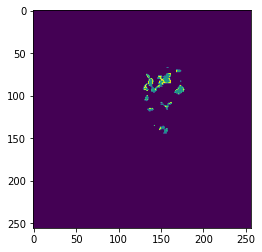

In [70]:
mask2 = create_mask(p2[:, 226, :, :])
plt.imshow(mask2)

In [120]:
subfolder4 = str(number3) + "_predict_bmp"

path6 = "01_perprocess/"+str(number3)+"/"+subfolder4

resize1 = 596

# export master_image
for i in range(predictions2.shape[1]):
    image = predictions[i,:,:,:].copy()
    image = rgb2gray(image)
#     image = np.where(image <= 0.6, 1, 0)
    image = image > 0
#     image = skimage.morphology.remove_small_objects(image, 20)
    image = rescale(image, (resize1/image.shape[0]), preserve_range=True, anti_aliasing=False)
#     image = (((image - image.min()) / (image.max() - image.min())) * 255.9).astype(np.uint8)
#     image = skimage.transform.rotate(image,90)
    image = np.where(image == True, 255, 0)
    img0 = Image.fromarray(image.astype(np.uint8))
#     img0 = ImageOps.grayscale(img0)
    img0.save(path6+"/"+str(number3)+"_pred_rec00000"+str("{0:03}".format(i))+".bmp")

In [ ]:
# test
def preprocess_image(file):
    # file is not a tensor, so we have to use functions that work on tensors
    img_string = tf.read_file(file)
    img = tf.image.decode_png(img_string)
    img = tf.image.resize_images(target_size)
    img = vgg16.preprocess_input(img)  # this function can handle tensors as well.
    return img


batch_size = 16
num_threads = 2
target_size=(256, 256)

files = [file1, file2, ...]
dataset = Dataset.from_tensor_slices(tf.constant(files))
dataset = dataset.map(preprocess_image, num_threads)
dataset = dataset.batch(batch_size)
dataset = dataset.prefetch(1)  
predictions = vgg_model.predict(dataset, steps=len(files) // batch_size)
# You could decode the predictions from here :)

In [55]:
# https://stackoverflow.com/questions/171765/what-is-the-best-way-to-get-all-the-divisors-of-a-number
from functools import reduce
def divisorGen(n):
    factors = list(range(1,101))
    nfactors = len(factors)
    f = [0] * nfactors
    while True:
        yield reduce(lambda x, y: x*y, [factors[x][0]**f[x] for x in range(nfactors)], 1)
        i = 0
        while True:
            f[i] += 1
            if f[i] <= factors[i][1]:
                break
            f[i] = 0
            i += 1
            if i >= nfactors:
                return